In [17]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy import optimize
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
from numpy.random import default_rng

In [18]:
from qiskit import QuantumCircuit, pulse, circuit, transpile, assemble, schedule
from qiskit.circuit import Gate
from qiskit.tools.monitor import job_monitor
from qiskit.pulse.library import GaussianSquare
from qiskit.providers.fake_provider import FakeAthens, FakeBoeblingenV2, FakeOpenPulse2Q


from qiskit import assemble
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [ ]:
def makepath(path):
    now = datetime.datetime.now()
    now = now.strftime('%Y_%m_%d__%H_%M_%S')
    now = str(now)
    path_now = os.path.join(path, now)
    if not os.path.exists(path_now):
        os.makedirs(path_now)
    print("figs saved in: {}".format(path_now))
    return path_now


def accept_rej(f, x, N):
    idx = np.arange(len(x))
    q_sample = rv_discrete(name='q_sample', values=(idx, f))
    sample_idx = q_sample.rvs(size=N)
    return x[sample_idx]


def complex2idx(original, cplx):
    return np.array([np.where(np.isin(original, cplx[i])) for i in range(len(cplx))]).reshape(len(cplx))


def build_query_circuit(U, M, t, cr_sched, ctrl_bit, tar_bit):
    cr_gate = circuit.Gate("cr", num_qubits=1, params=[])
    sim_circuit = QuantumCircuit(2,1)
    if U == 1:
        sim_circuit.x(ctrl_bit)
    sim_circuit.append(cr_gate, [ctrl_bit])
    sim_circuit.barrier()
    if M == 0:
        sim_circuit.sdg(tar_bit)
        sim_circuit.h(tar_bit)
    elif M == 1:
        sim_circuit.h(tar_bit)
    sim_circuit.barrier()
    sim_circuit.add_calibration(cr_gate, [ctrl_bit], cr_sched)
    sim_circuit.measure(tar_bit, 0)
    return sim_circuit

def build_cr_schedule(amp, query, backend, rise_ratio=0.1):
    ct_bit = 0
    tar_bit = 1
    with pulse.build(backend=backend) as cr_sched:
        ctrl_chan_01 = pulse.control_channels(ct_bit, tar_bit)[0]
        # pulse.play(GaussianSquare(int(query[-1]), amp, int(query[-1]*rise_ratio), risefall_sigma_ratio=1), ctrl_chan_01)
        pulse.play([amp]*int(query[-1]), ctrl_chan_01)
    circuit = build_query_circuit(*query, cr_sched, ct_bit, tar_bit)
    sim_transpiled = transpile(circuit, backend)
    return schedule(sim_transpiled, backend)


def mean_duplicate(data, cols=["t", "U"], is_duplicated=True, is_second=False):
    if is_duplicated:
        data_unique = data[(data[cols].duplicated(keep=False)==False)].reset_index(drop=True)
        data_dup = data[(data[cols].duplicated(keep=False)==True)].reset_index(drop=True)
        data_mean = data_dup.groupby(["t","U"]).mean().reset_index()
        if is_second:
            data_nan = data.loc[data["delta0"].isna()==True]
            return pd.concat([data_unique, data_mean, data_nan], join="inner").reset_index(drop=True)
        else:
            return pd.concat([data_unique, data_mean], join="inner").reset_index(drop=True)
    else:
        return data

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def rabi_oszillation(t, omega, delta):
    return 1-2*np.cos(delta)**2*np.sin(omega*t)**2


def fisher_infromation_matrix(t, omega_0, delta_0, omega_1, delta_1):
    A_0 = 4*t**2*np.cos(delta_0)**4*np.sin(2*omega_0*t)**2
    B_0 = -16*t**2*np.cos(delta_0)**3*np.sin(delta_0)*np.sin(omega_0*t)*np.cos(omega_0*t)
    C_0 = B_0
    D_0 = 16*np.cos(delta_0)**2*np.sin(delta_0)**2
    norm_0 = 1- (1-2*np.cos(delta_0)**2*np.sin(omega_0*t)**2)
    I_0 = np.array([[A_0, B_0], [C_0, D_0]])
    A_1 = 4*t**2*np.cos(delta_1)**4*np.sin(2*omega_1*t)**2
    B_1 = -16*t**2*np.cos(delta_1)**3*np.sin(delta_1)*np.sin(omega_1*t)*np.cos(omega_1*t)
    C_1 = B_1
    D_1 = 16*np.cos(delta_1)**2*np.sin(delta_1)**2
    norm_1 = 1- (1-2*np.cos(delta_1)**2*np.sin(omega_1*t)**2)
    I_1 = np.array([[A_1, B_1], [C_1, D_1]])

    if t != 0:
        return (np.kron(np.array([[0,0],[0,1]]), I_1) + np.kron(np.array([[1,0],[0,0]]), I_1))/(norm_0+norm_1)
    else:
        return np.eye(4)

def generate_fi_matrix(data, omega_0, delta_0, omega_1, delta_1):
    N_batch = data.shape[0]
    data.loc[data["U"]==0, "delta0"] = delta_0
    data.loc[data["U"]==1, "delta1"] = delta_1
    data.loc[data["U"]==0, "omega0"] = omega_0
    data.loc[data["U"]==1, "omega1"] = omega_1
    return np.array([fisher_infromation_matrix(data["t"].iloc[N], data["omega0"].iloc[N], data["delta0"].iloc[N], data["omega1"].iloc[N], data["delta1"].iloc[N]) for N in range(N_batch)])
    


def inv_weight_mat(weight, mat):
    weighted_mat = np.sum([abs(weight[i])*mat[i] for i in range(mat.shape[0])], axis=0)
    return np.trace(inv(weighted_mat))




def rabi_x(t, mu, eta, nu):
    alpha = np.arctan(np.sin(nu)/(np.cos(nu)*np.sin(eta)))
    return np.sin(2*eta)*np.cos(nu)/2+np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+alpha)
    # return np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+alpha)

def rabi_y(t, mu, eta, nu):
    gamma = np.arctan(np.cos(nu)/(np.sin(nu)*np.sin(eta)))
    return np.sin(2*eta)*np.sin(nu)/2-np.cos(eta)*np.sqrt(1-np.sin(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t-gamma)
    # return np.cos(eta)*np.sqrt(1-np.sin(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+gamma)

def rabi_z(t, mu, eta, nu):
    return 1-2*np.cos(eta)**2*np.sin(mu*t)**2

2.2222222222222221e-10


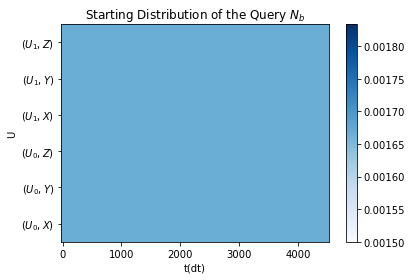

In [20]:
""""""""""""""""""""""""
"""  Programm Start  """
""""""""""""""""""""""""
path = "C:\\Physics_Master\\Master_Arbeit\\figs"
use_full = True
# path = makepath(path)

# use fake athens as the backend
backend = FakeAthens()
default = backend.defaults()

# use pulse simulator to simulate the pulse
backend_model= PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()
qubit_lo_freq = backend_model.hamiltonian.get_qubit_lo_from_drift()

dt = backend.configuration().dt
print(dt)

"""
Init Query distribution
"""

t_max = 10*1e-7
N_t = 100
ts = (np.linspace(0, t_max, N_t)/dt).astype(int)
Us = [0, 1]
Ms = [0, 1, 2]
N_UM = len(Us)*len(Ms)
UMs = np.zeros((N_UM,), dtype=object)
for i in range(len(Us)):
    for j in range(len(Ms)):  
        UMs[i*(len(Us)+1)+j]=np.array([Us[i], Ms[j]])   
dist_tUM = np.ones((N_UM, N_t))
dist_tUM = dist_tUM/dist_tUM.size


x = np.zeros((N_UM, N_t, 3), dtype=object)
q = np.zeros((N_UM, N_t), dtype=float)

for i in range(N_UM):
    for j in range(N_t):
        x[i,j,0] = UMs[i][0]
        x[i,j,1] = UMs[i][1]
        x[i,j,2] = ts[j]
        q[i,j] = dist_tUM[i,j]

U_label= [r"$(U_0, X)$",r"$(U_0, Y)$",r"$(U_0, Z)$",r"$(U_1, X)$",r"$(U_1, Y)$",r"$(U_1, Z)$"]
fake_UM = np.arange(N_UM)

plt.figure()
plt.pcolormesh(ts, fake_UM, q, cmap="Blues")
plt.colorbar()
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t(dt)')
plt.title(r'Starting Distribution of the Query $N_b$')
plt.show()

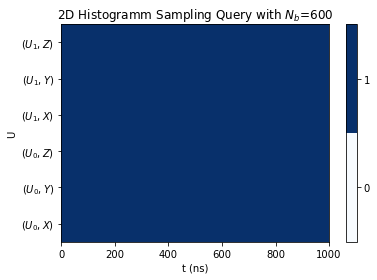

In [21]:
# N_sample_query=30

# querytest = accept_rej(q.reshape((q.size,)), x.reshape((q.size,3)), N_sample_query)
N_sample_query = N_UM*N_t
querytest = x.reshape((N_UM*N_t, 3))

xq = np.array([querytest[:,0], querytest[:,1]]).T.reshape((N_sample_query,2))
# yq = 

UM_complex = (np.meshgrid(Us,Ms)[0]+1j*np.meshgrid(Us,Ms)[1]).T.reshape(N_UM,)

data = pd.DataFrame()
data["U"] = querytest[:,0].astype(int)
data["M"] = querytest[:,1].astype(int)
data["t"] = querytest[:,2].astype(int)
data["UM"] = data["U"]+1j*data["M"]
UMidx = complex2idx(UM_complex, data["UM"])


H, xedges, yedges = np.histogram2d(data["t"]*dt*1e9, UMidx, bins=[N_t, N_UM])
H = H.T

binwidth = (N_UM-1)/N_UM/2
fake_UM = np.linspace(1, N_UM*2-1, N_UM)*binwidth

plt.figure()
colormesh = plt.pcolormesh(xedges, yedges, H, cmap=discrete_cmap(int(np.max(H)+1), "Blues"))
plt.colorbar(colormesh, ticks=range(int(np.max(H)+1)))
plt.clim(-0.5, int(np.max(H)+1) - 0.5)
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t (ns)')
plt.title(r'2D Histogramm Sampling Query with $N_b$={}'.format(N_sample_query))
plt.show()

In [22]:
if use_full == True:
    path = "C:\Physics_Master\Master_Arbeit\HAL_demo\hal_simulation\FakeAthenSimulation\\full_to\\"
    data = []
    for i in range(len(UMs)):
        dataname = "full_U{}_M{}.csv".format(UMs[i][0], UMs[i][1])
        data.append(pd.read_csv(path+dataname, index_col=0))

In [23]:
"""
Start first Measurement
"""
num_shots = 1024

counts = np.zeros(N_sample_query)

if use_full != True:
    for i in range(N_sample_query):
        """
        query format (U, M, t)
        """
        query = querytest[i]
        if query[2] == 0:
            counts[i] = 0
        else:
            pulse_schedule = build_cr_schedule(1.0+0j, query, backend=backend)

            test_qobj = assemble(pulse_schedule,
                                backend = backend_sim,
                                qubit_lo_freq = qubit_lo_freq,
                                meas_level = 1, 
                                meas_return = 'avg',
                                shots = num_shots)

            result = backend_sim.run(test_qobj, system_model=backend_model).result()
            # counts of the 1 in the simulation
            counts[i] = np.real(result.get_memory(0)[0])

    data["count"] = 1-2*counts

    #postprocess
    is_dup = np.sum(data[["t","U"]].duplicated())
    data_filtered = mean_duplicate(data, ["t","U"], is_dup)

In [ ]:
if use_full==True:
    sorted_data = data
else:
    sorted_data = [data.loc[data["UM"]==UM_complex[i]].sort_values(by="t") for i in range(N_UM)]

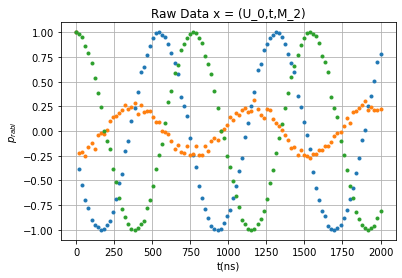

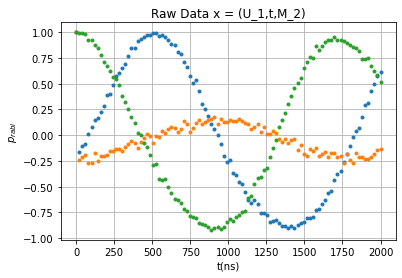

In [ ]:
for i in range(N_UM):
    # print(UMs[i])
    if i%3 == 0:
        plt.figure()
    plt.plot(sorted_data[i]["t"]*dt*1e9, sorted_data[i]["count"], ".")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0},t,M_{1})'.format(*UMs[i]))
    plt.grid()
    # plt.show()

Fitting Paper

[ 4.08809392e+06 -2.48470587e-01 -9.71966380e-01 -2.48703799e-01]


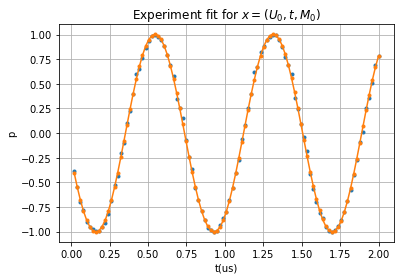

In [ ]:
# For fft
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# def inital_guess_freq(t, p, N_interp):
#     N = (len(t)-1)
#     T = np.max(t)/N
#     yf = fft(p.to_numpy())
#     y_fft = 2.0/N * np.abs(yf[0:N//2])
#     xf = fftfreq(N, T)[:N//2]*np.pi*2
#     peaks, properties = find_peaks(y_fft)
#     return xf[peaks][0], yf[peaks[0]]

def inital_guess_freq(t, p, N_interp):
    t_intp = np.linspace(0, t_max, N_interp, endpoint=False) #!Important, endpoint= False
    p_intp = np.interp(t_intp, t, p)
    T = t_max/N_interp
    yf = fft(p_intp)
    y_fft = 2.0/N_interp * np.abs(yf[0:N_interp//2])
    xf = fftfreq(N_interp, T)[:N_interp//2]*np.pi*2
    peaks = np.where(y_fft==np.max(y_fft))
    # print(1/t_max)
    # print(np.sum(p*np.exp(-1j*1e6*t)))
    # plt.plot(xf, [np.sum(p*np.exp(-1j*xf[i]*t)).real for i in range(len(xf))], ".")
    # plt.grid()
    # print(yf)
    return xf[peaks][0], yf[peaks[0]]

def find_coefficient(t, p, omg0, four_omg, n_data):
    n_rabi = n_data%3
    #fourier
    # four_o0_re = np.real(np.sum(p*np.exp(-1j*omg0*t)))
    # four_o0_im = -1*np.imag(np.sum(p*np.exp(-1j*omg0*t)))
    four_o0_re = np.real(four_omg)
    four_o0_im = -1*np.imag(four_omg)
    four_0 = np.sum(p)
    # print(four_0)
    k = omg0*t
    if n_rabi!=2:
        four = np.array([four_o0_re, four_o0_im]).reshape((2,1))
        M = np.array([[np.cos(k)*(np.cos(k)-1), np.cos(k)*np.sin(k)],
                    [np.sin(k)*(np.cos(k)-1), np.sin(k)**2]])
        M = np.sum(M, axis = 2)
        inv_M = np.linalg.inv(M)
        A = np.matmul(inv_M, four)[0][0]
        B = np.matmul(inv_M, four)[1][0]
        C = -A
    else:
        A = (np.sum(p)-len(t))/(np.sum(np.cos(k))-len(t))
        B = 0
        C = 1-A
    return A, B, C
# def find_coefficient(t, p, omg0, four_omg, n_data):
#     #fourier
#     # four_o0_re = np.real(np.sum(p*np.exp(-1j*omg0*t)))
#     # four_o0_im = -1*np.imag(np.sum(p*np.exp(-1j*omg0*t)))
#     four_o0_re = np.real(four_omg)
#     four_o0_im = -1*np.imag(four_omg)
#     four_0 = np.sum(p)
#     four = np.array([four_o0_re, four_o0_im, four_0]).reshape((3,1))

#     k = omg0*t
#     M = np.array([[np.cos(k)**2, np.cos(k)*np.sin(k), np.cos(k)],
#                   [np.cos(k)*np.sin(k), np.sin(k)**2, np.sin(k)],
#                   [np.cos(k), np.sin(k), np.array([1]*len(t))]])
#     M = np.sum(M, axis = 2)
#     inv_M = np.linalg.inv(M)
#     A = np.matmul(inv_M, four)[0][0]
#     B = np.matmul(inv_M, four)[1][0]
#     C = np.matmul(inv_M, four)[2][0]
#     # print(np.matmul(inv_M, four))
#     return A, B, C
    
def to_amp(A, B, C, n_data):
    n_rabi = n_data%3
    delta_C = (B**2-1)**2-4*C**2
    delta_A = (B**2-1)**2-4*A**2
    if n_rabi == 0:
        eta_C = np.arccos((0.5*((B**2+1)+delta_C**0.5))**0.5)
        eta_A = np.arccos((0.5*((B**2+1)+delta_A**0.5))**0.5)
        nu = np.arcsin(B/np.cos(eta_C))
    elif n_rabi == 1:
        eta_C = np.arccos((0.5*((B**2+1)+delta_C**0.5))**0.5)
        eta_A = np.arccos((0.5*((B**2+1)+delta_A**0.5))**0.5)
        nu = np.arccos(-1*B/np.cos(eta_C))
    elif n_rabi == 2:
        # print(np.abs(A)+np.abs(C))
        eta_A = np.arccos(np.sqrt(A))
        eta_C = np.arcsin(np.sqrt(C))
        nu = np.nan
    # print("Eta A, Eta C")
    # print(eta_A, eta_C)
    return eta_C, nu


def rough_fit_sorted_data(sorted_data, n_data):
    to_fit = sorted_data[n_data]
    t = (to_fit["t"].iloc[1:])*dt
    p = to_fit["count"].iloc[1:]
    mu, four_omg = inital_guess_freq(t, p, len(t)*2)
    A, B, C = find_coefficient(t, p, mu, four_omg, n_data*2)#
    # nu, eta = to_amp(A, B, C, n_data)
    # return mu, nu, eta
    return mu/2, A, B, C

"""
Fine fit model
"""


def fit_function(t, omg, A, B, C):
    return A*np.cos(2*omg*t)+B*np.sin(2*omg*t)-A+C

def fit_function_z(t, omg, A, B, C):
    return A*np.cos(2*omg*t)+(1-A)


def fit_sorted_data(sorted_data, n_data, inital_parameters):
    to_fit = sorted_data[n_data]
    t = to_fit["t"].iloc[1:]*dt
    p = to_fit["count"].iloc[1:]
    y_label= (to_fit["U"][0],to_fit["M"][0])
    # print(y_label.real, y_label.imag)
    n_rabi = n_data%3
    if n_rabi !=2:
        result = optimize.curve_fit(fit_function, t, p, p0=inital_parameters)
        p_fit1 = fit_function(t, *result[0])
    else:
        result = optimize.curve_fit(fit_function_z, t, p, p0=inital_parameters)
        p_fit1 = fit_function_z(t, *result[0])
    plt.figure()
    plt.plot(t*1e6, p, ".")
    plt.plot(t*1e6, p_fit1, ".-")
    plt.grid()
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r"Experiment fit for $x = (U_{0}, t, M_{1})$".format(y_label[0], y_label[1]))
    plt.ylabel("p")
    plt.xlabel("t(us)")
    print(result[0])
    return result[0]

rough_parameters = np.zeros((6,4))
fine_parameters = np.zeros((6,4))
for i in range(6):
    rough_parameters[i,:] = rough_fit_sorted_data(sorted_data, i)
    fine_parameters[i,:] = fit_sorted_data(sorted_data, i, rough_parameters[i,:])
    break

In [ ]:
for i in range(6):
    print(rough_parameters[i,:])
    # print(fine_parameters[i,1:])

[ 3.14159265e+06 -1.80187093e+00 -5.52254634e-01  1.80187093e+00]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [ ]:
def to_amp(A, B, C, n_data):
    n_rabi = n_data%3
    delta_C = (B**2-1)**2-4*C**2
    delta_A = (B**2-1)**2-4*A**2
    if delta_A < 0:
        print("delta A not defined for data "+str(n_data))
    elif delta_C < 0:
        print("delta C not defined for data "+str(n_data))

    if n_rabi == 0:
        eta_C = np.arccos((0.5*((B**2+1)+delta_C**0.5))**0.5)
        eta_A = np.arccos((0.5*((B**2+1)+delta_A**0.5))**0.5)
        nu = np.arcsin(B/np.cos(eta_C))
    elif n_rabi == 1:
        eta_C = np.arccos((0.5*((B**2+1)+delta_C**0.5))**0.5)
        eta_A = np.arccos((0.5*((B**2+1)+delta_A**0.5))**0.5)
        nu = np.arccos(-1*B/np.cos(eta_C))
    elif n_rabi == 2:
        print("z condition")
        print(np.abs(A)+np.abs(C))
        eta_A = np.arccos(np.sqrt(A))
        eta_C = np.arcsin(np.sqrt(C))
        nu = np.nan
    # print("Eta A, Eta C")
    # print(eta_A, eta_C)
    return eta_C, nu

amp = np.zeros((6,3))
for i in range(6):
    amp[i, 0] = fine_parameters[i,0]
    amp[i, 1:] = to_amp(*fine_parameters[i,1:], i)
amp

delta A not defined for data 0
z condition
0.0
z condition
0.0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7796\787138174.py:11: RuntimeWarning: invalid value encountered in double_scalars
  eta_C = np.arccos((0.5*((B**2+1)+delta_C**0.5))**0.5)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7796\787138174.py:12: RuntimeWarning: invalid value encountered in double_scalars
  eta_A = np.arccos((0.5*((B**2+1)+delta_A**0.5))**0.5)


array([[4.08809392e+06,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
       [0.00000000e+00, 0.00000000e+00,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
       [0.00000000e+00, 0.00000000e+00,            nan]])

In [ ]:
def to_J1(paras):
    mus = paras[:,0]/(2*np.pi)
    Bs = paras[:,2]
    Cs = paras[:,3]
    mu0 = np.mean(mus[:3])
    mu1 = np.mean(mus[3:])
    J_IX = -0.5*(mu0*Bs[1]+mu1*Bs[4])
    J_IY = 0.5*(mu0*Bs[0]+mu1*Bs[3])
    J_IZ = 0.5*(mu0*Cs[2]**0.5+mu1*Cs[5]**0.5)
    J_ZX = -0.5*(mu0*Bs[1]-mu1*Bs[4])
    J_ZY = 0.5*(mu0*Bs[0]-mu1*Bs[3])
    J_ZZ = 0.5*(mu0*Cs[2]**0.5-mu1*Cs[5]**0.5)
    return np.array([J_IX, J_IY, J_IZ, J_ZX, J_ZY, J_ZZ])

to_J1(fine_parameters)

array([     -0.        , -105400.09177873,       0.        ,
            -0.        , -105400.09177873,       0.        ])

In [ ]:
# def to_J2(paras):
#     mu0 =# 

Transform parameters

In [ ]:
def FI_M(t, mu, eta, nu):
    I_mu_mu = 4*t**2*np.cos(eta)**2*np.cos(mu*t)**2/(1-np.cos(eta)**2*np.sin(mu*t)**2)
    I_mu_eta = -2*t**2*np.cos(2*eta)/( np.tan(mu*t)*(1-np.cos(eta)**2*np.sin(mu*t)**2))
    I_eta_eta = 4*np.sin(eta)**2/(np.sin(mu*t)**2*(1-np.cos(eta)**2*np.sin(mu*t)**2))
    

### Save data


In [ ]:
# for i in range(len(sorted_data)):
#     sel_data = sorted_data[i].reset_index()
#     sel_data.to_csv("C:\Physics_Master\Master_Arbeit\HAL_demo\hal_simulation\FakeAthenSimulation\\control_1amp_0_3_riserate\\full_U{}_M{}.csv".format(sel_data["U"][0], sel_data["M"][0]))